# [IceBridge Alaska](https://www.nasa.gov/image-feature/operation-icebridge-exploring-alaska-s-mountain-glaciers) Altimetry Analysis Tools

#### Code Developers: Anthony Arendt, Evan Burgess, Chris Larsen, Christian Kienholz

These codes import the altimetry data from UAF to the RDS database.

## Overview

The Alaska altimetry code depends heavily on a backend PostgreSQL database for storing and analyzing mass balance trends. This originates from extensive use of PostgreSQL/PostGIS for generating the Alaska glacier inventory which eventually formed the basis for the Randolph Glacier Inventory. This notebook is used to create a new/manage and existing relational database storing the Alaska-altimetry products. This code can only be run with admin privliges.

### Database host location

We have experimented with hosting the database in several locations over the years. For some time it was served from a computer located in the University of Alaska Fairbanks glaciology group. Currently we host the database on an Amazon Web Services Relational Database System (RDS).

### Creating the database

Before running any of the code below, these steps are required:

* connect to the database with admin privilges
* create a new database called "Alaska-altimetry"
* in a SQL command window, enabl the PostGIS extension: ```CREATE EXTENSION postgis;```
* run new_lamb_table.sql located in "../sql" directory


### Managing users

* create role: 'admin' with 'postgres' priviliges (corresponds to "ice2oceansdb-admin" in env file): this user can run the codes below for generating new tables, etc.
* create role: 'altimetryuser' with login priviliges. Run: ```GRANT SELECT ON ALL TABLES IN SCHEMA public TO altimetryuser;``` ((corresponds to "ice2oceansdb-altimetryuser" in env file): this user represents general reserachers working with database queries


#### Import libraries, including custom AltPy tools

In [1]:
import yaml
import pandas as pd

import AltPy.Altimetry as alt
import AltPy.UpdateDb as updatedb

#### Read in credentials needed to connect to the ftp site storing the raw data, and the relational database storing analysis products

In [2]:
credentials = yaml.load(open('../.env.yaml'), Loader=yaml.FullLoader)

#### If importing new data, connect here to the ftp site at UAF

Start with a list of glaciers you want to acquire from UAF. Build this as a pandas dataframe.

In [4]:
# create some dummy data for now. This should be read in later.

data = [['Tsina', 'G214033E61262N'],['BlackRapids', 'G213472E63469N']]
  
# Create the pandas DataFrame 
glacierNames = pd.DataFrame(data, columns = ['name', 'glimsid']) 

tempDirectory = 'data/'

### upload all the data to the database

In [ ]:
updatedb.get_ftp_data(credentials['UAF-ftp'], credentials['ice2oceansdb-admin'], 
                      glacierNames, tempDirectory)

Some tests to make sure we can read back data ingested to the db

In [5]:
engine, cursor = alt.ConnectDb(credentials['ice2oceansdb-Altimetry-user'])

In [6]:
cursor.execute('Select * from lamb')

# Building glacier geometry files

These altimetry scripts rely on glacier polygons from the [Randolph Glacier Inventory](https://www.glims.org/RGI/). Area and hyposemtric information from these polygons enable us to calculate glacier-wide mass balances from centerline altimetry profiles (for measured glaciers) and to extrapolate observations from measured to unmeasured glaciers.

Our process is to acquire the RGI data in our own database so that we can query it as needed for our anlysis. The ingest of RGI to the database only needs to be done once.

These are the steps for getting the RGI data into the database:

* download the Alaska RGI from the [NSIDC/Global Land Ice Measurements from Space website]((https://www.glims.org/RGI/)).
* connect to the database as administrator
* import the shapefile to a table called "modern" using one of several PostGIS extensions. For example, use QGIS


In [ ]:
%matplotlib inline
from matplotlib.pyplot import *

# Lets look at a timeseries of Taku elevation change profiles

#Selecting all of the non-overlapping altimetry intervals available for taku
taku = alt.GetLambData(credentials['ice2oceansdb-Altimetry-user'],by_column=False,as_object=False) 

#Plotting

for t in taku:
    plot(t['e'],t['dz'],label="%s - %s" % (t['date1'].year,t['date2'].year))
legend(loc=4)
xlabel('Elevation (m)')
ylabel('Elevation Change Rate (m/yr)')


The LiDAR Altimetry data and glacier geometry data used in [Larsen et al.(2015)]() are stored in the following table structure.  The key point to understand is that here we do not start from the raw LiDAR point clouds. Instead, the table lamb  contains the surface elevation change rate profiles for each glacier over each possible interval. Each row was in this table was generated using a semi-manual step (discussed in Arendt et al., [2002] and Johnson et all. [2013]), where a user defines a bin size, a glacier polygon etc. and then runs a matlab script called 'lamb' to generate a top-bottom profile of surfaceelevation change rates. This script also outputs the along profile IQR of the measured surface elevation change and the mass balance integrated across the user defined glacier polygon.  All of this data is included in the lamb table. The only part of the lamb table used by Larsen et al., is the elevation change rate profile and the IQR for each glacier and the glacier geometry is extracted from the ergi table and ergi_mat_view materialized view.

The glacier geometry is provided by a modified version of the RGI 4.0 called the ergi.  The ergi has some differences that accomodate the UAF Altimetry flightlines.  Important glacier attributes including Glacier name, terminus type,surge-type,and region are all stored as points.  We then run a spatial join with the ergi to create a materialzed view of the ergi table with the appropriate attributes.  The ergi has also been split into 30 m elevation bins using the DEM described in Kienholz et al. [2015] to capture every glacier hypsometry in ergibins.


### Altimetry.Altimetry.GetSqlData2(select, bycolumn = False)

#### Purpose:
Extract data from the default database using sql query and return data organized by either row or column. This just condenses the above code into one line and insures all of your code is working off the same database.
    
#### Arguments:     

<dl><dt>select</dt><dd>Any postgresql select statement as string including ';'</dd></dl>

#### Keyword Arguments:
<dl><dt>bycolumn</dt><dd>Set to True to request that data be returned by column instead of row.</dd></dl>

#### Returns: 
If data is returned by row (default) the requested data will be stored as a list of dictionaries where each
row in the output table is stored as a dictionary where the keys are the column names.  

If you request bycolumn, each column in the output table is accessed though a dictionary where the key is the column name.  Each column of data is stored in that dictionary as a list or as a numpy array.  

If you request a MULTIPOLYGON geometry, the geometry will be extracted into a list of coordinates for the
outer ring and another list of inner rings (which is another list of coordinates).  Data is stored in the 
dictionary as keys 'inner' and 'outer'.  If there are no inner rings, None is returned.

#### Example:

In [3]:
# Lets find the which glaciers have areas greater than 1000 sq. km.
data = alt.GetSqlData("SELECT name,area FROM ergi_mat_view WHERE area>1000 ORDER BY area DESC;",bycolumn=False)
for glacier in data:
    print "{name} has an area of {area:.0f} sq. km.".format(**glacier)

Seward Glacier has an area of 3363 sq. km.
Bering Glacier has an area of 3025 sq. km.
Hubbard Glacier has an area of 2834 sq. km.
Logan Glacier has an area of 1177 sq. km.
Kaskawulsh Glacier has an area of 1054 sq. km.
Nabesna Glacier has an area of 1029 sq. km.
Yahtse Glacier has an area of 1019 sq. km.
Tana Glacier has an area of 1003 sq. km.


### Altimetry.Altimetry.GetLambData(\*args,\**kwargs)

#### Purpose:
This is the primary function to extract Laser Altimetry Mass Balance (LAMB) data from the database. The key point to understand is that this code does not calculate mass balance from the raw LiDAR point clouds that are also stored in ice2oceans database. Instead, GetLambData queries a table called lamb that contains the surface elevation change profiles for each glacier over each possible interval.  Each profile in this table was generated using a semi-manual step (discussed in Arendt et al., (2002) and Johnson et all. (2013)), where a user defines a bin size, a glacier polygon etc and then runs a matlab script called 'lamb' to generate a top-bottom profile of surface elevation change rates.  This script also outputs the along profile IQR of the measured surface elevation change and the mass balance integrated across the user defined glacier polygon.  All of this data is included in the lamb table and output by GetLambData.  The only part of 'lamb' used by Larsen et al., is the elevation change rate profile and the IQR for each glacier. This script will retrieve Lambdata for any group of glaciers and survey intervals.  It contains keywords for you to filter what intervals you would like.  It will also return the glacier polygon from the RGI (the one used in Larsen et al., [2015] not Johnson et al. [2013]), the glacier hypsometry, and the Larsen et al., 2015 
mass balance estimate for that glacier.
    
#### Keyword Arguments:        
<dl>

<dt>removerepeats</dt><dd>Set to True to select only the shortest/non-overlapping intervals for each glacier. Set to false to include all data.  Default Value=True</dd>

<dt>longest_interval</dt><dd>Set to True to retreive only the single longest interval available for each glacier.</dd>

<dt>days_from_year</dt><dd>Set the number of days away from 365 to be considered.  For example if you want annual 
                    intervals to be within month of each other leave default of 30. If you want sub-annual 
                    (seasonal data) set to 365.  Default Value = 30</dd>

<dt>interval_min</dt><dd>Minimum length of interval in years. This is a rounded value so inputing 1 will include
                    an interval of 0.8 years if it passes the days_from_year threshold above. Default = 0 </dd>

<dt>interval_max</dt><dd>Maximum length of interval in years. This is a rounded value so inputing 3 will include
                    an interval of 3.1 years if it passes the days_from_year threshold  above. Default = None</dd>

<dt>earliest_date</dt><dd>Earliest date of first acquistion. Enter as string 'YYYY-MM-DD'. Default = None</dd>

<dt>latest_date</dt><dd>Latest date of second acquistion. Enter as string 'YYYY-MM-DD'. Default = None</dd>

<dt>userwhere</dt><dd>Enter as string.  User can input additional queries as a string to a where statement. Any fields in ergi_mat_view or lamb are valid. Example input:"name NOT LIKE '%Columbia%' AND area > 10". Default=""</dd> 

<dt>verbose</dt><dd>Verbose output. Default = True</dd>

<dt>get_geom</dt><dd>Set to True to retrieve the geometry of the glacier polygon</dd>

<dt>generalize</dt><dd>Set to a value to simplify geometries</dd>

<dt>by_column</dt><dd>Get data organized by column instead of by lamb file (Default=True)</dd>

<dt>as_object</dt><dd>Get data output as a LambObject.  Only works if by_column = True (Default=True)</dd>

<dt>get_glimsid</dt><dd>Set to true to retrieve each glaciers glimsid as well.</dd>

<dt>results</dt><dd>Set to true to retrieve the mass balance of the glacier as is estimated by Larsen et. al. (2015).  Note the larsen et al mass balance is returned regardless of the interval you chose for that glacier.</dd></dl>

#### Returns: 
A dictionary or a lamb object with all attributes available in lamb as well as glacier parameters
available in ergi_mat_view for the selection of surveyed glacier intervals chosen.
 
#### Example:

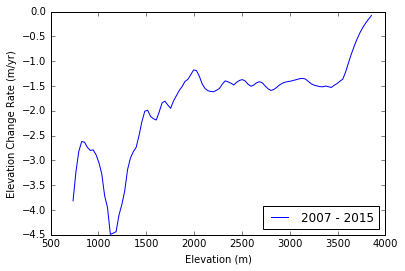

In [4]:
%matplotlib inline
from matplotlib.pyplot import *

# Lets look at a timeseries of Taku elevation change profiles

#Selecting all of the non-overlapping altimetry intervals available for taku
taku = alt.GetLambData(removerepeats=True,by_column=False,as_object=False, userwhere="ergi_mat_view.name='Regal Glacier'") 

#Plotting

for t in taku:
    plot(t['e'],t['dz'],label="%s - %s" % (t['date1'].year,t['date2'].year))
legend(loc=4)
xlabel('Elevation (m)')
ylabel('Elevation Change Rate (m/yr)')

### class   Altimetry.Altimetry.LambObject()

GetLambData can output data as a dictionary, as shown above, but it can also output the same data as an instance of a lamb object or a list of lamb objects.  This not only makes life easier syntactically, it also provides access to an assortment of important methods available to this object class.  Each lamb oject will contain attributes whose name and value correspond to matching fields in the database:

 Attribute     |   Data Type   |     Description
 ------------- |:-------------:|:-----
lambid |       integer | Primary Key
ergiid |       integer | foreign key to ergi
date1 |        date | First Acquisition Date
date2 |        date | Second Acquisition Date
interval |      smallint | Interval Length (days)
volmodel |        real | Gacier-wide mass balance in Gt/yr: not used for Larsen et al., [2015]
vol25diff |        real | Gacier-wide mass balance 25th percentile error estimate in Gt/yr: not used for Larsen et al., [2015]
vol75diff |        real | Gacier-wide mass balance 75th percentile error estimate in Gt/yr: not used for Larsen et al., [2015]
balmodel |        real | Gacier-wide mass balance in m w. e./yr: not used for Larsen et al., [2015]
bal25diff |        real | Gacier-wide mass balance 25th percentile error estimate in m w. e./yr: not used for Larsen et al., [2015]
bal75diff |        real | Gacier-wide mass balance 75th percentile error estimate in m w. e./yr: not used for Larsen et al., [2015]
e |       integer[] | Elevation of bottom of bin (m)
dz |        real[] | Surface elevation change rate along elevation profile specified by e (m/yr)
dz25 |        real[] | Surface elevation change rate variability: 25th percentile along elevation profile specified by e (m/yr)
dz75 |        real[] | Surface elevation change rate variability: 75th percentile along elevation profile specified by e (m/yr)
aad |        real[] | Area Altitude Distribution for the surveyed glacier determined using a polygon drawn by an UAF LiDAR altimetry tech and may/may not be the RGI polygon. Note this AAD was not used for Larsen et al. [2015].
masschange |        real[] | Lamb output: not used for Larsen et al., 2015 (units?)
massbal |        real[] | Lamb output: not used for Larsen et al., 2015 (units?)
numdata |       integer[] | Number of crossing points in Bin
ergiid |  integer | Primary key to ergi table
area |  numeric | Glacier Area
min |  numeric | Min elevation of the glacier defined by the RGI 4.0
max |  numeric | Max elevation of the glacier defined by the RGI 4.0
continentality |   real | Distance from coast (polygon centerpoint) units(?)
albersgeom | geometry(MultiPolygon,3338) | Alaska Albers Polygon Geometry of the glacier boundary
name |   character varying(45) | Glacier Name
gltype |  integer | Terminus Type 0=land,1=tide,2=lake
surge |  boolean | Surge-Type Glacier?
region |   character varying(50) | Region defined by Larsen et al., 2015 that this glacier is in
arendtregion |  integer | Region defined by Arendt et al., 2002 that this glacier is in



<hr>
Using a LambObject, we can do the same thing as before but using a object output you will see the syntax is cleaner:

list


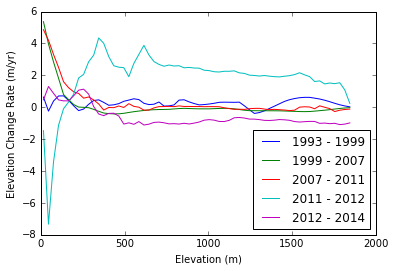

In [5]:
import Altimetry as alt
%matplotlib inline
from matplotlib.pyplot import *

#Lets look at the Taku timeseries
#Note the only thing different from above is as_object is set to 'True'
taku = alt.GetLambData(removerepeats=True,by_column=False,as_object=True, userwhere="ergi_mat_view.name='Taku Glacier'") 

#Plotting
for t in taku:
    plot(t.e,t.dz,label="%s - %s" % (t.date1.year,t.date2.year))
legend(loc=4)
xlabel('Elevation (m)')
ylabel('Elevation Change Rate (m/yr)')

***
Lamb objects also have several important methods designed to work with the lambObject in column form (i.e. set by_column = True). That will help you perform standard operations to the sample you have selected.  Try to use them in this order.

* convert085( )
* fix_terminus(slope=-0.05,error=1)
* remove_upper_extrap(remove_bottom=True,erase_mean=True,add_mask=True)
* normalize_elevation( )
* calc_dz_stats(too_few=4)
* extend_upper_extrap( )
* calc_mb(units='area normalized')
* convert085
* get_approx_location  

### Altimetry.Altimetry.LambObject.convert085( )

#### Purpose:
Convert attributes dz,dz25 and dz75 to units of water equivalent instead of surface elevation change.
    
#### Returns: 
None

#### Example:

object


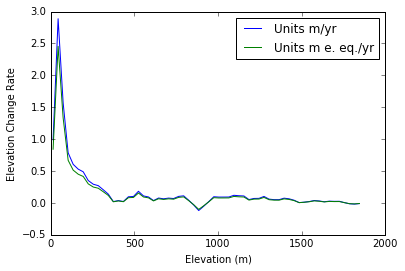

In [6]:
%matplotlib inline
from matplotlib.pyplot import *
#Lets look at the Taku timeseries
taku = alt.GetLambData(longest_interval=True,by_column=True,as_object=True, userwhere="ergi_mat_view.name='Taku Glacier'") 

plot(taku.e[0],taku.dz[0],label='Units m/yr')
taku.convert085()
plot(taku.e[0],taku.dz[0],label='Units m e. eq./yr')
legend()
xlabel('Elevation (m)')
ylabel('Elevation Change Rate')

### Altimetry.Altimetry.LambObject.fixterminus( ) 

#### Purpose:
Correct profile's for a retreating terminus as exemplified in figure S11, [Larsen et al., 2015].  Specifically it changes dz,dz25 and dz75.
                   
#### Keyword Arguments:
<dl><dt>slope</dt><dd>The threshold used to determine how steep the reduction in thinning rate needs to be 
to qualify as a section that needs to be corrected.  I played with this a lot and the
default value of -0.05 worked best.</dd>
<dt>error</dt><dd>The 1 quartile width to set as the error for the corrected portion of the profile</dd></dl>

#### Returns: 
None

#### Example:

object


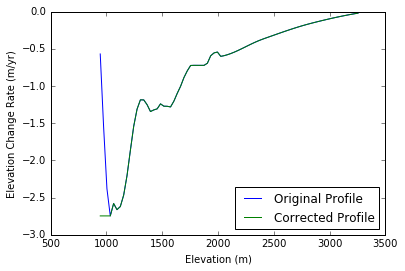

In [7]:
%matplotlib inline
#Lets look at the Gillam timeseries
gillam = alt.GetLambData(longest_interval=True,by_column=True,as_object=True, userwhere="ergi_mat_view.name='Gillam Glacier'") 

plot(gillam.e[0],gillam.dz[0],label='Original Profile')
gillam.fix_terminus()
plot(gillam.e[0],gillam.dz[0],label='Corrected Profile')
legend(loc=4)
xlabel("Elevation (m)")
ylabel("Elevation Change Rate (m/yr)")

### Altimetry.Altimetry.LambObject.remove_upper_extrap(remove_bottom=True,erase_mean=True) 

#### Purpose:
The LAMB matlab code extrapolates to the glacier head and glacier terminus when data does not make it 
all of the way to the top or bottom of the glacier hypsometry.  While this is needed when estimating individual glacier mass balance, it isn't really appropriate when using the profile to extrapolate to other glaciers.  This method removes those extrapolations by masking the top and bottom. Removing the bottom is optional with the keyword remove_bottom.

#### Keyword Arguments

* remove_bottom
    * set to false to only remove top.  Default = True
* erase_mean
    * Set to False to keep the mean and only delete the dz25 and dz75 fields.  Default = True

#### Returns: 
None

#### Example:

object


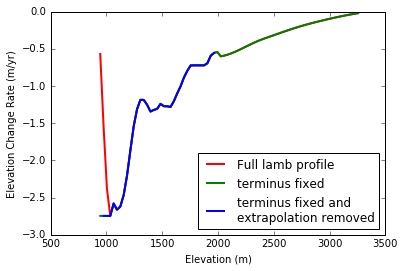

In [8]:
%matplotlib inline
#Lets look at the Gillam timeseries
gil = alt.GetLambData(longest_interval=True,by_column=True,as_object=True, userwhere="ergi_mat_view.name='Gillam Glacier'") 

plot(gil.e[0],gil.dz[0],'r',lw=2,label='Full lamb profile')

gil.fix_terminus()
plot(gil.e[0],gil.dz[0],'g',lw=2,label='terminus fixed')

gil.remove_upper_extrap()
plot(gil.e[0],gil.dz[0],'b',lw=2,label='terminus fixed and \nextrapolation removed')
#best to go in this order!

legend(loc=4)
xlabel("Elevation (m)")
ylabel("Elevation Change Rate (m/yr)")

### Altimetry.Altimetry.LambObject.normalize_elevation( )

#### Purpose:
Normalize the elevation range in the elevation bins listed in lamb.  This normalization assumes the 
max and min elevation is that available in the ergi table fields max and min.  This function 
creates and updates the class attributes: self.norme,self.normdz,self.norm25,self.norm75,
self.survIQRs. This works for an individual glacier or a group within the object.
                   
#### Keyword Arguments:
* gaussian
    * Set to True to place a gaussian smooth over the normalized data

#### Returns:
None

But adds the following attributes to the object: self.norme, self.normdz, self.norm25, self.norm75, self.survIQRs


* norme
    * The normalized elevation of each bin where 0.00 is the glacier bottom 1 is the glacier top.
* normdz
    * The mean elevation change rate profile on the normalized elevation scale.
* norm25,norm75, survIQRs
    * The 1st and 3rd quartiles and the IQR on the normalized scale</dd></dl>
            
#### Example:

object


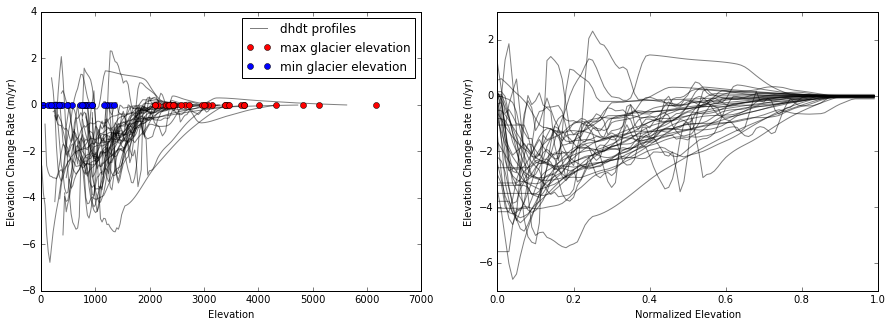

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

#Lets look at the Gillam timeseries
akrng = alt.GetLambData(longest_interval=True,by_column=True,as_object=True, userwhere="region = 'Alaska Range'") 

fig = plt.figure(figsize=[15,5])
ax1=fig.add_subplot(121)

#PLOTTING ELEVATION PROFILES AND MAX AND MIN ELEVATION OF EACH GLACIER IN THE ALASKA RANGE
labels = ['dhdt profiles','max glacier elevation', 'min glacier elevation']
for e,dz,x,n in zip(akrng.e,akrng.dz,akrng.max,akrng.min):
    ax1.plot(e,dz,'k',label=labels[0],zorder=1,alpha=0.5)
    ax1.plot(x,0,'ro',label=labels[1])
    ax1.plot(n,0,'bo',label=labels[2])
    
    #only labeling each type once
    labels=[None,None,None]

ax1.legend()
ax1.set_xlabel('Elevation')
ax1.set_ylabel("Elevation Change Rate (m/yr)")

#PLOTTING THE SAME PROFILES BUT NORMALIZED
akrng.normalize_elevation()

ax2=fig.add_subplot(122)
ax2.set_xlabel('Normalized Elevation')

ax2.set_ylabel("Elevation Change Rate (m/yr)")
for n in akrng.normdz:ax2.plot(akrng.norme,n,'k',alpha=0.5)

### Altimetry.Altimetry.calc_mb.LambObject.calc_mb()

#### Purpose:
Adds a new attribute to the Lamb object self.mb which is a glacier mass balance estimate given the lamb 
data, a normalized surface elevation change profile (from normalize_elevation) and a glacier hypsometry
(run GetLambData with 'get_hypsometry=True').  This works for an individual glacier or a group within 
the object.
                  
calc_mb(self,units='area normalized')
  
#### Keyword Arguments:
* units
    * Set to either 'gt' or 'area normalized'

#### Returns:
* None
    * However, self.mb is set to the mb in the units specified

#### Example:

glimsid = G212893E63657N
{'normbins': array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,
        0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.37,  0.38,
        0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,
        0.48,  0.49,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,  0.57,
        0.58,  0.59,  0.6 ,  0.61,  0.62,  0.64,  0.65,  0.66,  0.67,
        0.68,  0.69,  0.7 ,  0.71,  0.72,  0.73,  0.74,  0.75,  0.76,
        0.78,  0.79,  0.8 ,  0.81,  0.82,  0.83,  0.84,  0.85,  0.86,
        0.87,  0.88,  0.89,  0.9 ,  0.92,  0.93,  0.94,  0.95,  0.96,
        0.97,  0.98,  0.99,  0.99]), 'binned_area': array([  2.22823000e+05,   7.39385000e+05,   9.92011000e+05,
         9.90115000e+05,   1.15405000e+06,   1.29920000e+06,
         1.30126000e+06,   1.18990000e+06,   1.27579000e+06,
         1.37134000e+06,   

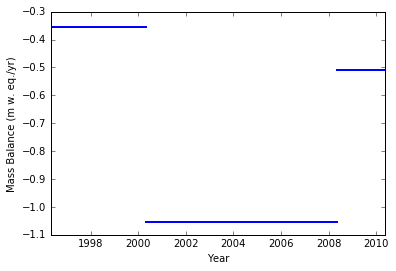

In [10]:
#Let's look at the altimetry mass balance timeseries for Bering Glacier.
import Altimetry as alt
bering = alt.GetLambData(removerepeats=True,by_column=True,as_object=True, userwhere="ergi_mat_view.name='Gillam Glacier'",get_hypsometry=True)
bering.normalize_elevation()
bering.calc_mb()

for d1,d2,mb in zip (bering.date1,bering.date2,bering.mb):
    plot_date([d1,d2],[mb,mb],'-b',lw=2,label="{d1} - {d2}".format(d1=d1.year,d2=d2.year))
xlabel('Year')
ylabel("Mass Balance (m w. eq./yr)")

[Go to Table of Contents](#toc)
### Altimetry.Altimetry.LambObject.calc_dz_stats()<a name='calc_dz_stats'></a>

#### Purpose:

Calculates various statistics for the sample within the object. Requires that one run normalize_elevation 
first.
                  
calc_dz_stats(masked_array=False,too_few=None)
  
#### Keyword Arguments:
<dl><dt>too_few</dt><dd>When calculating kurtosis we normaly require samples to be larger than 4.  If you happen to be choosing groups with a sample size smaller than 4, set this to None and ignore the Kurtosis, and for that matter skew etc. as that is a really small sample.  (Default = 4)  </dd></dl>

#### Result:
Adds the following attributes to the lamb object:
<dl><dt>quadsum</dt><dd>Quadrature sum of the sample along profile (m/yr) along the normalized profile.  Used as an estimate of surveyed glacier uncertainty for the region when integrated over all surveyed glaciers in this sample.  </dd>  
<dt>dzs_std</dt><dd>Standard Deviation along the normalized profile.</dd>  
<dt>dzs_mean</dt><dd>Mean surface elevation change rate (m/yr) along the normalized profile.</dd> 
<dt>dzs_median</dt><dd>Median surface elevation change rate (m/yr) along the normalized profile.</dd> 
<dt>dzs_madn</dt><dd>NormalizedMAD of surface elevation change rate (m/yr) along the normalized profile.</dd> 
<dt>dzs_sem</dt><dd>Standar error of the mean (m/yr) along the normalized profile. Used as an estimate of surveyed glacier uncertainty for the region when integrated over all unsurveyed glaciers</dd> 
<dt>normalp</dt><dd>P-value probablitiy of normality along profile</dd> 
<dt>skewz/p</dt><dd>Z-score and p-value for test of whether the sample elevation change rates have a skew that is non-normal along profile.</dd> 
<dt>kurtz/p</dt><dd>Z-score and p-value for test of whether the sample elevation change rates have a skew that is non-normal along profile.</dd> 
<dt>skew</dt><dd>The skew of the distribution along profile.</dd> 
<dt>kurtosis</dt><dd>The kurtosis of the distribution along profile.</dd> 
<dt>percentile_5</dt><dd>The 5th percentile of the distribution along profile (m/yr).</dd> 
<dt>quartile_1</dt><dd>The first quartile of the distribution along profile (m/yr).</dd> 
<dt>percentile_33</dt><dd>The 33rd percentile of the distribution along profile (m/yr).</dd> 
<dt>percentile_66</dt><dd>The 66th percentile of the distribution along profile (m/yr).</dd> 
<dt>quartile_3</dt><dd>The 3rd quartile of the distribution along profile (m/yr).</dd> 
<dt>percentile_95</dt><dd>The 95th percentile of the distribution along profile (m/yr).</dd> </dl>   

#### Example:

object
(35, 100)


Altimetry.py:886: RuntimeWarning: invalid value encountered in double_scalars
  var = (N.sum((ptspercell - N.mean(ptspercell))**2))/(ptspercell.size-1)


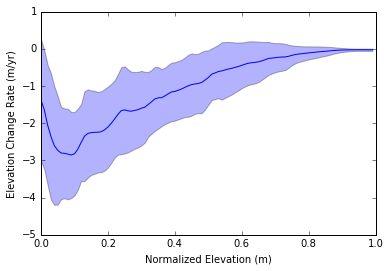

In [11]:
%matplotlib inline
from matplotlib.pyplot import *
#Lets look at the distribution of elevation changes in the Wrangells
wra = alt.GetLambData(longest_interval=True,interval_max=30,interval_min=5,by_column=True,as_object=True, \
                      userwhere="ergi_mat_view.region='Alaska Range'") 
wra.normalize_elevation()
wra.calc_dz_stats()

#Plotting the mean surface elevation profile
plot(wra.norme,wra.dzs_mean)
#Plotting the standard deviation of surface elevation changes
fill_between(wra.norme,wra.dzs_mean+wra.dzs_std,wra.dzs_mean-wra.dzs_std,alpha=0.3)
xlabel("Normalized Elevation (m)")
ylabel("Elevation Change Rate (m/yr)")

### Altimetry.Altimetry.LambObject.extend_upper_extrap()<a name='extend_upper_extrap'></a>

#### Purpose:
Depending on the sample of glaciers you choose, you may run into samples where none of the surveys cover dhdt values at the top or bottom of the normalized elevation curve.  Thus you may not have any stats at the top or bottom of the elevation curve.  In these cases we this function will extend all of the stats from the last known data point at the top or bottom.  This is generally only needed and best to run prior to using 'extrapolation'. If no extension is needed the data will not be changed.

### Alitmetry.Altimetry.partition_dataset()<a name='partition_dataset'></a>

### Purpose:
This function simplifies partitioning the altimetry dataset in (almost) anyway the user would like for purposes 
of running the extrapolate function to estimate the regional mass balance. Here the user specifies a list of "WHERE" clauses that select samples that can then be used to represent some segment of glaciers from the ergi. This function simply loops through GetLambData and returns a list of Lamb objects and assumes you are desiring the longest interval available for each glacier.  The example should be very helpful in how to use this function.
       
#### Argument:
<dl>
<dt>partitioning</dt><dd>A list of strings that would go into where statements that describe each partition individually. In larsen et al. we divide our extrapolation by terminus type. So we
have three groups, each with a where statement that says either "gltype=0","gltype=1",
or "gltype=2".  Thus this input is a list as ["gltype=0","gltype=1","gltype=2"].  Do not include the "WHERE or ANDs."
This list must be as long as the number of groups you are partitioning.<dd/>
</dl>

#### Keyword Arguments:

<dl><dt>apply_to_all</dt><dd>There may also be requirments that apply to all of the groups.  In our example above, we don't want surge glaciers or a few specific outliers.  Requirements for all groups are listed here, as in the example above.  You can list as many or as few (None) as you want.</dd>

<dt>interval_min</dt>
<dt>interval_max</dt><dd>This has a similar effect to apply to all, it is just a easier way to specify requirements
                on the interval length. Numbers can be entered as an int. (Default = 5,30 for min and max
                respectively)</dd> 

<dt>too_few</dt><dd>When calculating kurtosis we normaly require samples to be larger than 4.  If you happen
                to be choosing groups with a sample size smaller than 4 set this to None and ignore the 
                Kurtosis, and for that matter skew etc. as that is a really small sample.  (Default = 4) </dd></dl> 
                
####Returns: 

A 5 element list of the following: lamb,userwheres,notused,whereswo,notswo

<dl>
<dt>lamb</dt><dd>A list of LambObjects for each of the partitioned groups specfied in the paritioning argument.
These are in the same order as in partitioning argument.  If any of the groups requested have
no glaciers in them, that LambObject is excluded from this list.</dd> 

<dt>userwheres</dt><dd>A list of where statements that were used to filter altimetry intervals for each group.  This 
combines the where statments in partitioning, apply_to_all and interval_min/max .  Note if no
glaciers exist in that group, the where is not output here, and instead will come out in
notused.</dd>

<dt>notused</dt><dd>A list of the groups specified by partitioning that have no glaciers in them. The where 
statements in a list are returned here.</dd>

<dt>whereswo</dt><dd>Same as userwheres but does not include the where statements associated with the apply_to_all
argument.  This is useful when used with extrapolate.</dd>

<dt>notswo</dt><dd>Same as notused but does not include the where statements associated with the apply_to_all
argument.</dd>
</dl>
                    
#### Example:
See example with extrapolate below.

### Altimetry.Altimetry.extrapolate(\*args,\**kwargs)

#### Purpose:
This function extrapolates to unsurveyed glaciers and returns estimates of mass balance for all glaciers,
including surveyed glaciers in the ERGI. This function is intended to work with partition dataset where
partition dataset splits the altimetry dataset up into samples and then this function applies those
sample mean curves to glaciers of choice.  There are key subltetys to how this works so pay attention here.
In effort to give the user the maximum flexibility this function will allow you to give yourself results
that make no sense.  So you must be careful and also examine your outputs.  There is an example below.
            
#### Arguments:
* user
    * Input a string that states the user name.  This funtion will output a table with the name alt_result_[user]X where X is 1 or if the user has a table already this script will not over-write so the number will be increased incrementally.  This will prevent different users from
confusing their results.
                    
* groups
        * A list lamb objects output by partition dataset, each element in the list is a single curve that the user intends to apply to some group of glaciers.  It is critical here to note that the glaciers that receive a specifc elevation profile do NOT need to be at all related to theglaciers that made the profile.  This will be clarified further on.  

* selections
    * A list of strings that specify where statements that describe where each group from the group argument should be applied.  This should be of the same length and same intended order of the lamb list presented for the groups argument.  The KEY here is that the user must insure that the selections together, include EVERY SINGLE glacier in the ergi AND don't ever have overlapping selections either.  Said another way the selections list must be comprehsive of the glacier inventory and each selection is mututally exclusive of the others.  See the example below for 
further clarification.                 
                    
#### Keyword Arguments:
* insert\_surveyed\_data
    * Set to a lamb object that includes glaciers, for which, you would like to insert the actual surveyed glacier profile into the regional estimate.  If this keyword is left blank, we use the extrapolation curves are applied to all glaciers in the selections argument even if they were surveyed glaciers (Default = one)

* keep\_postgres\_tbls
    * Set to True if the user wishes to retain the output dataset (Default=False).  If so, this table will be called alt_result_[user]X
                            
* export_shp
     * Set to a pathname if the user would like to output the table as a shpfile for viewing in a GIS.
   
* density
    * Set to the assumed density (Default=0.85)
    
* density_err
    * Set to the assumed density uncertainty (Default=0.06)
    
* acrossgl_err
    * Set to the assumed across glacier uncertainty (Default=0.0)                  
    
#### Returns: 
A dictionary of dictionaries containing partitioned mass balance results. Where glaciers are divided in the following ways. The following dictionary keys are returned regardless of your partitioning choices:
            
* bysurveyed
    * Mass balance of glaciers divided by whether they were 'surveyed' or 'unsurveyed' for the data input.
* bytype
    * same but divided by terminus type.
* all
    * Same but the region as a whole.
* bytype_survey
    * Same but divided by terminus type and whether they were 'surveyed' or 'unsurveyed' for the data input.

Within each of these groups the summed mass balance is presented in another dictionary with keys:

* area
    * Total area of group
* totalkgm2
    * Mean mass balance in m w eq/yr  (yes it says kgm2)
* errkgm2
     * Mean mass balance error in m w eq/yr  (yes it says kgm2)
* totalgt
    * Total mass balance Gt/yr
* errgt
    * Total mass balance error Gt/yr. Note this does not include the 50% increase in error for tidewater glaciers nor the area dependency correction that is discused in larsen et al.  Those should to be added manually if the user wishes.
    
If the keyword keep_postgres_tbls=True, the result table will be retained in the database and will allow the user to query and view this table (in a GIS) to evaluate the extrapolation further.         
      
#### Example use with GetLambData AND partition_dataset: 

In [ ]:
%matplotlib inline
import Altimetry as alt
#Retreiving all of the surveyed glacier data in one lambobject
#to be applied those glaciers individually as surveyeddata.
surveyeddata = alt.GetLambData(verbose=False,longest_interval=True,interval_max=30,interval_min=5,by_column=True, as_object=True)
surveyeddata.fix_terminus()
surveyeddata.normalize_elevation()
surveyeddata.calc_dz_stats()
types = ["gltype=0","gltype=1","gltype=2"]
lamb,userwheres,notused,whereswo,notswo = alt.partition_dataset(types,applytoall=["surge='f'","name NOT IN ('Columbia Glacier','West Yakutat Glacier','East Yakutat Glacier')"])

#Lastly, runing extrapolate on those groups.
#this applies the group extrapolation to each group but we use the where statements include exceptions 
# like surgers. To reiterate, we ran partition_dataset on land/lake/tide w/o surgers.  
# But we apply those same curves to land/lake/tides but to all glaciers
# including surgers.  Here, ther user has then inserted the surveyed data so surveyed glacier mass balance 
 #is included on an individual
# glacier basis.  Lastly here we drop the output_table, please do this as the output table is several Gb. 

results = alt.extrapolate('guest',lamb,whereswo,insert_surveyed_data=surveyeddata,keep_postgres_tbls=True)  

In [ ]:
results

In [ ]:
%matplotlib inline
from matplotlib.pyplot import *
import numpy as N
#Plotting a pie chart of the total amount of mass lost from each glacier type.
typenames = {'0':'Land','1':'Tidewater','2':'Lake'}
labels = [typenames[i] for i in results['bytype']['gltype'].astype(str)]
figure(figsize=(3,3))
pi = pie(N.abs(results['bytype']['totalgt']),labels=labels)

## Updates, Packages, Settings
<a name="settings"></a>

### Modifying the hostname/database/login in the Altimetry module

If you need to change the hostname, database or username used by the altimetry module, find or download the source code for the Altimetry package. The directory should be called Altimetry-X.X.  Inside that directory should be a directory called 'Altimetry' along with a README, PKG-INFO and a setup.py file.  Go into the Altimetry directory and open the \__init\__.py file. Change the database settings in the dictionary defined as 'defaulthost' and save the file.  Then, while in the Altimetry-X.X directory, execute

`python setup.py install`

at the commandline.  Restart ipython notebook server if it is running and thats it.


